In [126]:
import requests
import json
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta, datetime 

# Create a date list containing all dates in %Y-%m-%d format from 2021-09-01 to current day
start_date = date(2021, 9, 1) 
end_date = date.today()

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

date = []
for single_date in daterange(start_date, end_date):
    date.append(single_date.strftime("%Y-%m-%d"))

print(date[:10])

['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08', '2021-09-09', '2021-09-10']


In [127]:
# Ran for 3 minutes for 43 days of data

base_url = 'http://rata.digitraffic.fi/api/v1/trains/'
url = base_url + date[0]

data = [] # store data from start date till today 
for day in date:
    r = requests.get(url)
    res = r.json()
    for obj in res:
        if obj["trainType"] == "HL": # only store the commuter trains
            data.append(obj)
    url = base_url + day

print(len(data))


35938


In [134]:
delay = []
for obj in data:
    for instance in obj['timeTableRows']:
        try: # data is dirty, avoid KeyError
            scheduledTime = datetime.strptime(instance['scheduledTime'], '%Y-%m-%dT%H:%M:%S.000Z')
            actualTime = datetime.strptime(instance['actualTime'], '%Y-%m-%dT%H:%M:%S.000Z')
            lag = (actualTime - scheduledTime).total_seconds()
            delay.append(lag)
        except:
            continue

delay = np.array(delay, dtype=np.int32)

In [135]:
print("Number of train rides for which I calculated delays:", len(delay))
print("Number of outliers:", len(delay[(delay < -600) | (delay > 600)]), "(where delay was larger than +- 600 seconds)")
print("Number of instances where train arrived earlier than scheduled:", len(delay[(delay<0)]))
positive_delay = delay[delay>=0]
print("Average positive delay", positive_delay.mean())
print("Standard deviation of positive delay", positive_delay.std())
print("Median of positive delay", np.median(positive_delay))

Number of train rides for which I calculated delays: 1421091
Number of outliers: 12071 (where delay was larger than +- 600 seconds)
Number of instances where train arrived earlier than scheduled: 107793
Average positive delay 81.49977232890022
Standard deviation of positive delay 137.39727167248097
Median of positive delay 47.0


Standard deviation of positive delay after filtering out outliers 81.17785173201756


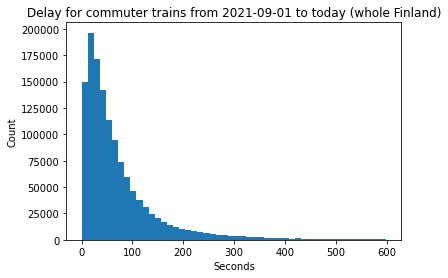

In [141]:
# filter out hard outliers (>10 minutes)
positive_delay = positive_delay[positive_delay < 600]
plt.hist(positive_delay, 50)
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.title("Delay for commuter trains from 2021-09-01 to today (whole Finland)")
print("Standard deviation of positive delay after filtering out outliers", positive_delay.std())

In [137]:
import requests
import json

base_url = 'http://rata.digitraffic.fi/'
url = base_url + '/api/v1/trains/2018-08-12'

r = requests.get(url)
res = r.json()
len(res)

1262

In [140]:
def count_per_train_type(data):
    '''Returns a dictionary containing (trainType, count) key-value pairs'''
    counts = {}
    for obj in data:
        if obj["trainType"] in counts:
            counts[obj["trainType"]] += 1
        else:
            counts[obj["trainType"]] = 0
    return counts

count_per_train_type(res)

{'IC': 104,
 'S': 30,
 'PVV': 1,
 'PYO': 0,
 'HSM': 3,
 'HDM': 40,
 'P': 5,
 'AE': 7,
 'T': 170,
 'HL': 563,
 'VET': 108,
 'HV': 15,
 'MV': 9,
 'SAA': 76,
 'PAI': 72,
 'W': 12,
 'VEV': 4,
 'TYO': 24,
 'LIV': 0}

In [139]:
def different_train_types(data):  
    '''Returns a dictionary containing (trainType, trainCategory) key-value pairs'''  
    types = {}
    for obj in data:
        types[obj["trainType"]] = obj["trainCategory"]
    return types 

different_train_types(res)

{'IC': 'Long-distance',
 'S': 'Long-distance',
 'PVV': 'Long-distance',
 'PYO': 'Long-distance',
 'HSM': 'Long-distance',
 'HDM': 'Long-distance',
 'P': 'Long-distance',
 'AE': 'Long-distance',
 'T': 'Cargo',
 'HL': 'Commuter',
 'VET': 'Locomotive',
 'HV': 'Commuter',
 'MV': 'Long-distance',
 'SAA': 'Shunting',
 'PAI': 'Shunting',
 'W': 'Shunting',
 'VEV': 'Shunting',
 'TYO': 'On-track machines',
 'LIV': 'Test drive'}